# Import libraries

In [1]:
import pandas as pd
import numpy as np

from pprint import pprint
import re
import string

import operator
from collections import Counter

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

In [3]:
# gensim
from gensim import corpora, models, similarities, matutils
# logging for gensim (set to INFO)
import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
# gensim LDA model visualization
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# To Plot matplotlib figures inline on the notebook
%matplotlib inline

import seaborn as sns
sns.set()
sns.set(font_scale = 2)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 5)
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

# Load the MedDRA filtered DSLD Dataframe

In [6]:
# read the dataframe
DS_label_select_df = pd.read_pickle('data/DietarySupplementLabelDatabasePrecautionsFiltered.pkl')

In [7]:
print('Dataframe dimensions:', DS_label_select_df.shape)
print('Dataframe Columns:')
pprint(list(DS_label_select_df.columns), compact=True)

Dataframe dimensions: (16966, 23)
Dataframe Columns:
['Brand', 'LanguaL_Product_Type', 'LanguaL_Supplement_Form', 'Product_Name',
 'Serving_Size', 'Ingredient_Categories', 'Ingredient_Count',
 'Ingredient_Synonym_Source', 'Has_FDA_Disclaimer', 'Other_Statements',
 'Precautions', 'Dietary_Claim_or_Use_P0065', 'Dietary_Claim_or_Use_P0264',
 'Dietary_Claim_or_Use_P0124', 'Dietary_Claim_or_Use_P0115',
 'Dietary_Claim_or_Use_P0276', 'Dietary_Claim_or_Use_P0265',
 'Intended_Target_Groups_P0253', 'Intended_Target_Groups_P0192',
 'Intended_Target_Groups_P0266', 'Intended_Target_Groups_P0250', 'MedDRA_SE',
 'MedDRA_SE_text']


In [8]:
DS_label_select_df.sample(5)

,Brand,LanguaL_Product_Type,LanguaL_Supplement_Form,Product_Name,Serving_Size,Ingredient_Categories,Ingredient_Count,Ingredient_Synonym_Source,Has_FDA_Disclaimer,Other_Statements,...,Dietary_Claim_or_Use_P0124,Dietary_Claim_or_Use_P0115,Dietary_Claim_or_Use_P0276,Dietary_Claim_or_Use_P0265,Intended_Target_Groups_P0253,Intended_Target_Groups_P0192,Intended_Target_Groups_P0266,Intended_Target_Groups_P0250,MedDRA_SE,MedDRA_SE_text
DSLD_ID,,,,,,,,,,,,,,,,,,,,,
13032,Nature's Plus,"DIETARY SUPPLEMENT, MINERAL [A1299]",TABLET [E0155],Nature's Plus Multi-Trace Minerals Trace-Mins,1.0 Tablet(s),mineral,1,"Trace Mineral Complex (Actinium, Aluminum, A...",True,Free from artificial colors and preservatives....,...,False,True,False,True,False,False,False,True,"[poisoning, overdose, accidental_overdose]",poisoning overdose accidental_overdose
67477,Nature's Bounty,"DIETARY SUPPLEMENT, VITAMIN [A1302]",SOFTGEL CAPSULE [E0161],Nature's Bounty D3 5000 IU,1.0 Softgel(s),vitamin,1,Vitamin D (as D3 (Cholecalciferol) ),True,Your Sunshine Vitamin\n\nGuaranteed Quality\n\...,...,False,True,False,True,False,False,False,True,[sarcoidosis],sarcoidosis
24238,Innate Response Formulas,"DIETARY SUPPLEMENT, COMBINATION, OTHER [A1325]",TABLET [E0155],Innate Response Formulas Baby & Me Trimester I...,4.0 Tablet(s),"Vitamin, mineral, other, header, vitamin, bact...",57,"Tocotrienols (D-Alpha {Tocotrienol}, D-Beta ...",False,"- GMP Compliant, 100% WHOLE FOOD\n\nWhole Plan...",...,False,True,False,False,True,False,False,False,"[poisoning, overdose, accidental_overdose]",poisoning overdose accidental_overdose
57330,Douglas Laboratories,"DIETARY SUPPLEMENT, COMBINATION, OTHER [A1325]",POWDER [E0162],Douglas Laboratories Organic Greens & Reds,1.0 Scoop(s) [approx. 8 grams]Alternate 8.0 ...,"blend, other, header, carbohydrate, polysaccha...",38,"organic Parsley powder (aerial parts), Protea...",False,"USDA Organic, Suggested Usage: As a dietary su...",...,False,True,False,False,False,False,False,True,[pregnancy],pregnancy
15900,health PLUS inc,"DIETARY SUPPLEMENT, COMBINATION, OTHER [A1325]",POWDER [E0162],health PLUS inc Super Colon Cleanse Powder,2.0 Teaspoon(s) [10 g]Alternate 10.0 g [2 Te...,"mineral, other, carbohydrate, vitamin, botanic...",11,"Calories, Total Carbohydrates, Proprietary Ble...",True,"ALL NATURAL MADE WITH HERBS NO FILLERS, COLON ...",...,False,True,False,True,False,False,False,True,"[abdominal_pain, pain, choking, poisoning, loo...",abdominal_pain pain choking poisoning loose_st...


# Convert text to vectors

## Build the vocabulary of side effects

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist if len(item)>0]
se_vocab_ = set(flatten(DS_label_select_df['MedDRA_SE']))
print('Length of side effects vocabulary: {}'.format(len(se_vocab_)))

## Build gensim dictionary

In [9]:
# Build a Dictionary - association word to numeric id
dictionary = corpora.Dictionary(DS_label_select_df['MedDRA_SE'])

In [10]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
corpus_dict = [dictionary.doc2bow(text) for text in DS_label_select_df['MedDRA_SE']]

In [11]:
print('Number of unique tokens: {}'.format(len(dictionary)))
print('Number of documents: {}'.format(len(corpus_dict)))

Number of unique tokens: 662
Number of documents: 16966


# Topic Modeling

## LDA model with different number of topics

In [12]:
number_of_words = sum(cnt for document in corpus_dict for _, cnt in document)

In [13]:
def evaluate_graph(dictionary, corpus, texts, limit, step_size):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    
    per_word_perplexity = []
    lm_list = []
    topics_range = range(20, limit+1, step_size)
    for num_topics in topics_range:
        print('Building LDA model with {} number of topics.'.format(num_topics))
        lm = models.LdaModel(corpus=corpus, num_topics=num_topics, alpha='auto', iterations=200,
                               id2word=dictionary, passes=50, eval_every=None, random_state=2018)
        lm_list.append(lm)
        cm = models.CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        per_word_perplexity.append(np.exp2(-lm.bound(corpus) / number_of_words))
        c_v.append(cm.get_coherence())
        
    return lm_list, c_v, per_word_perplexity

In [14]:
limit=150
step_size=10
topics_range = range(20, limit+1, step_size)
lmlist, c_v, per_word_perplexity = evaluate_graph(dictionary=dictionary, corpus=corpus_dict, 
                             texts=DS_label_select_df['MedDRA_SE'], 
                             limit=limit, step_size=step_size)

Building LDA model with 20 number of topics.
Building LDA model with 30 number of topics.
Building LDA model with 40 number of topics.
Building LDA model with 50 number of topics.
Building LDA model with 60 number of topics.
Building LDA model with 70 number of topics.
Building LDA model with 80 number of topics.
Building LDA model with 90 number of topics.
Building LDA model with 100 number of topics.


/home/ubuntu/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Building LDA model with 110 number of topics.
Building LDA model with 120 number of topics.
Building LDA model with 130 number of topics.
Building LDA model with 140 number of topics.
Building LDA model with 150 number of topics.


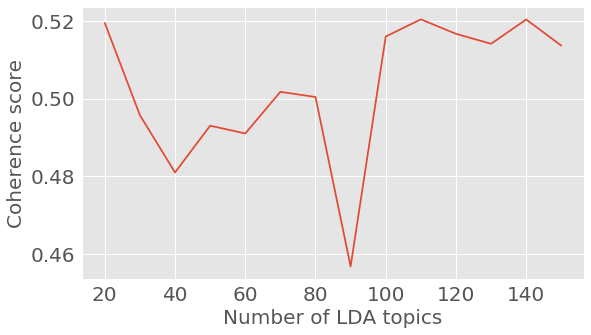

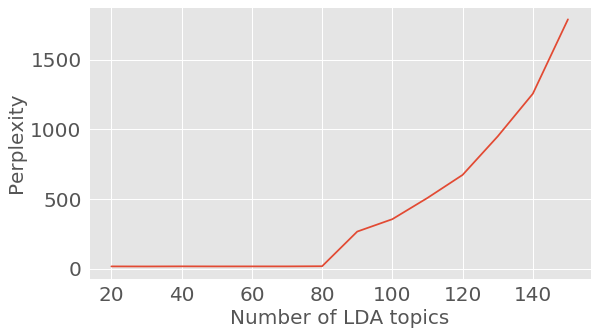

In [15]:
# Show graph
plt.plot(topics_range, c_v);
plt.xlabel("Number of LDA topics", fontsize=20);
plt.ylabel("Coherence score", fontsize=20);
plt.show()
plt.plot(topics_range, per_word_perplexity);
plt.xlabel("Number of LDA topics", fontsize=20);
plt.ylabel("Perplexity", fontsize=20);

# Get the conditional probability of each topic given a particular supplement

In [30]:
# load the saved LDA model
opt_lda_model = lmlist[7] #number of topics=90

In [31]:
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_opt_corpus = opt_lda_model[corpus_dict]
# Store the documents' topic vectors in a list so we can take a peak
lda_opt_docs = [doc for doc in lda_opt_corpus]
print('Number of documents:', len(lda_opt_docs))

Number of documents: 16966


In [32]:
# Assign each supplement to the topic that has the maximal conditional probability
DS_label_select_df['BestTopicID'] = ([sorted(topic_prob_pair, 
                                             key=lambda tup: tup[1], 
                                             reverse=True)[0][0] 
                                      for topic_prob_pair in lda_opt_docs
                                     ])
print('Dimensions:', DS_label_select_df.shape)

Dimensions: (16966, 24)


In [33]:
def get_lda_topic_words(topicID):
    threshold = 0.02
    top_terms_tup = opt_lda_model.show_topic(topicID, topn=20)
    return [tup[0] for tup in top_terms_tup if tup[1] >= threshold]

In [34]:
# Append the words associated with the topic whose probabilities > 0.05
DS_label_select_df['BestTopicTerms'] = DS_label_select_df['BestTopicID'].apply(get_lda_topic_words)

# Topic Evaluation

## Count the number of supplements under each topic

In [35]:
# Make twin axis
def make_twin_axis(ax, ncount, maxfreq=100, ylabel='Frequency [%]'):
    
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right');
    ax2.yaxis.set_label_position('left');

    ax2.set_ylabel(ylabel, fontsize=25);

    # Fix the frequency range to 0-100
    ax2.set_ylim(0,maxfreq);
    ax.set_ylim(0,ncount/(100/maxfreq));
    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(10))
    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(maxfreq/10))
    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None);
    # Annotate the bars
    for p in ax.patches:
        x_bar=p.get_bbox().get_points()[:,0]
        y_bar=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}'.format(100.*y_bar/ncount), (x_bar.mean(), y_bar), 
                    ha='center', va='bottom', fontsize=15) # set the alignment of the text

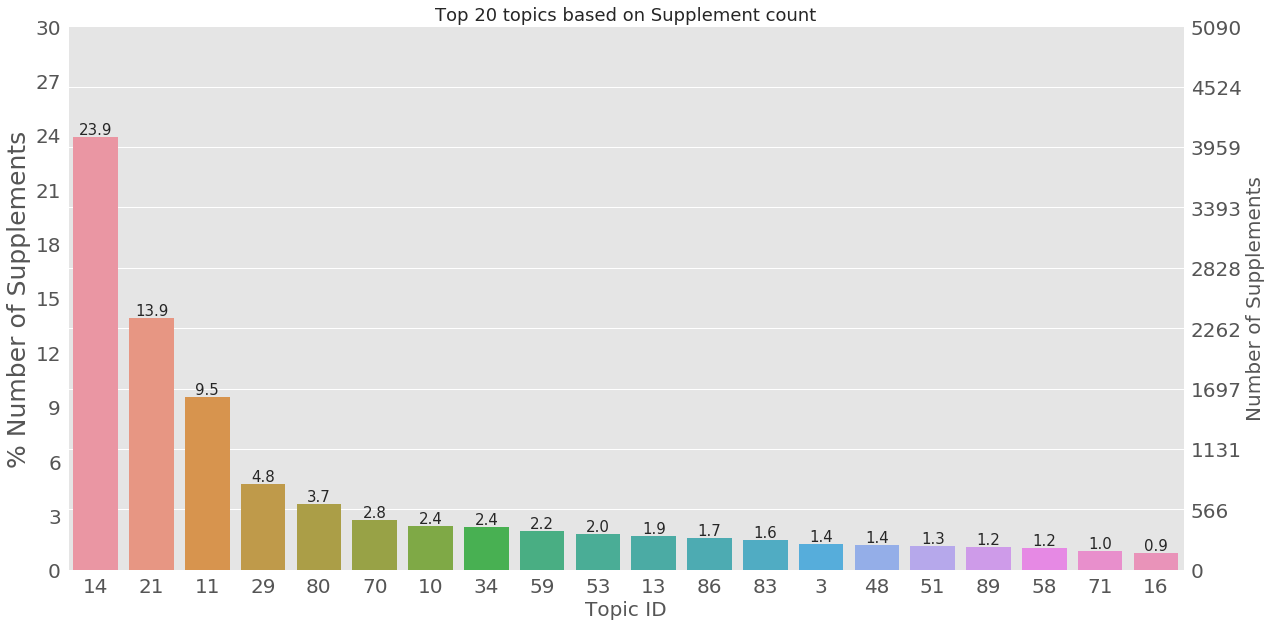

In [42]:
ncount = len(DS_label_select_df)
fig = plt.figure(figsize=(20, 10))
ax = sns.countplot(x='BestTopicID', data=DS_label_select_df,
              order = DS_label_select_df['BestTopicID'].value_counts().iloc[:20].index);
make_twin_axis(ax, ncount, 30, '% Number of Supplements')
ax.set_ylabel('Number of Supplements', fontsize=20);
ax.set_xlabel('Topic ID', fontsize=20);
ax.set_title('Top 20 topics based on Supplement count');

## Count the number of terms with probability > threshold in each topic and select only topics: 1. which have more than 1 term in them 2. which have 10-50 supplements in them

In [44]:
DSL_topic_df = DS_label_select_df['BestTopicID'].value_counts().to_frame(name='Number_of_Supplements')
DSL_topic_df.index.name = 'TopicID'
DSL_topic_df.reset_index(inplace=True);
DSL_topic_df['Terms'] = DSL_topic_df['TopicID'].apply(get_lda_topic_words)
DSL_topic_df['Number_of_Terms'] = DSL_topic_df['Terms'].apply(lambda lst:len(lst))
DSL_topic_df.head() 

,TopicID,Number_of_Supplements,Terms,Number_of_Terms
0,14,4049,[surgery],1
1,21,2358,[pregnancy],1
2,11,1620,"[overdose, accidental_overdose, poisoning]",3
3,29,806,"[overdose, accidental_overdose, poisoning]",3
4,80,620,"[pain, abdominal_pain, loose_stools]",3


In [45]:
DSL_topic_select_df = DSL_topic_df[(DSL_topic_df['Number_of_Terms']>3) & 
                                   (DSL_topic_df['Number_of_Supplements']<=150) &
                                   (DSL_topic_df['Number_of_Supplements']>=20)]
print('Number of topics Selected based on supplements and terms count: ', len(DSL_topic_select_df))

Number of topics Selected based on supplements and terms count:  19


In [46]:
print('In selected topics dataframe, ')
print('Topic {} has the maximum number of supplements of {}'
      .format(DSL_topic_select_df['TopicID'].loc[DSL_topic_select_df['Number_of_Supplements'].argmax()],
              DSL_topic_select_df['Number_of_Supplements'].max()))
print('Topic {} has the minimum number of supplements of {}'
      .format(DSL_topic_select_df['TopicID'].loc[DSL_topic_select_df['Number_of_Supplements'].argmin()],
              DSL_topic_select_df['Number_of_Supplements'].min()))

In selected topics dataframe, 
Topic 60 has the maximum number of supplements of 137
Topic 87 has the minimum number of supplements of 21


## Get all supplement information for the selected topics

In [47]:
final_selected_topics = DSL_topic_select_df['TopicID'].unique()
print('Number of topics selected for further analysis: {}'.format(len(final_selected_topics)))

Number of topics selected for further analysis: 19


In [48]:
DS_label_topic_select_df = DS_label_select_df[DS_label_select_df['BestTopicID'].isin(final_selected_topics)].copy()
print('Dataframe dimensions:', DS_label_topic_select_df.shape)
print('Selected number of topics:', DS_label_topic_select_df['BestTopicID'].nunique())
print('Selected topics:\n', list(DS_label_topic_select_df['BestTopicID'].unique()))

Dataframe dimensions: (1491, 25)
Selected number of topics: 19
Selected topics:
 [5, 67, 65, 27, 82, 31, 0, 30, 78, 60, 79, 84, 74, 73, 28, 35, 88, 69, 87]


In [49]:
selected_columns = ['Product_Name', 'BestTopicID', 
                    'Ingredient_Synonym_Source', 'Ingredient_Categories',
                    'Precautions', 'MedDRA_SE', 'BestTopicTerms']
DS_label_topic_select_df[selected_columns].head()

,Product_Name,BestTopicID,Ingredient_Synonym_Source,Ingredient_Categories,Precautions,MedDRA_SE,BestTopicTerms
DSLD_ID,,,,,,,
76923,365 Everday Value Milk Thistle Liver Cleanse,5,Milk Thistle (Silybum marianum) seed extract ...,botanical,Produced in a facility that processes tree nut...,"[inflammation, intestinal_obstruction, gastroi...","[inflammation, gallbladder_disorder, obstructi..."
1176,5-Hour Energy 5-Hour Energy Berry,67,"Energy Blend, Protease, N-Acetyl L-Tyrosine, C...","mineral, blend, other, header, enzyme, vitamin...",CAUTION: Contains about as much caffeine as a ...,"[nervousness, feeling_hot, hot_flush, redness]","[redness, clotting, feeling_hot, skin_irritati..."
1177,5-Hour Energy 5-Hour Energy Grape,67,"Folic Acid, Vitamin B12 (as Cyanocobalamin),...","mineral, vitamin, other",CAUTION: Contains caffeine comparable to a cup...,"[nervousness, feeling_hot, hot_flush, redness]","[redness, clotting, feeling_hot, skin_irritati..."
33566,ABS Alpha Bitch Supplements Vixen Heat,65,"Rhodiola rosea extract (Rhodiola rosea) (3%),...","vitamin, botanical, other",WANING: Do not take Vixen Heat in excess of it...,[heat_stroke],"[dehydration, low, liver_disorder, cardiac_dis..."
60619,Action Labs Yohimbe Power Max 2000,27,Yohimbe bark extract (bark) (in a matrix of)...,"mineral, blend, other, botanical, fiber",Not recommended for use by persons under the a...,"[hypertension, inflammation]","[hypertension, hypotension, skin_warm, drug_to..."


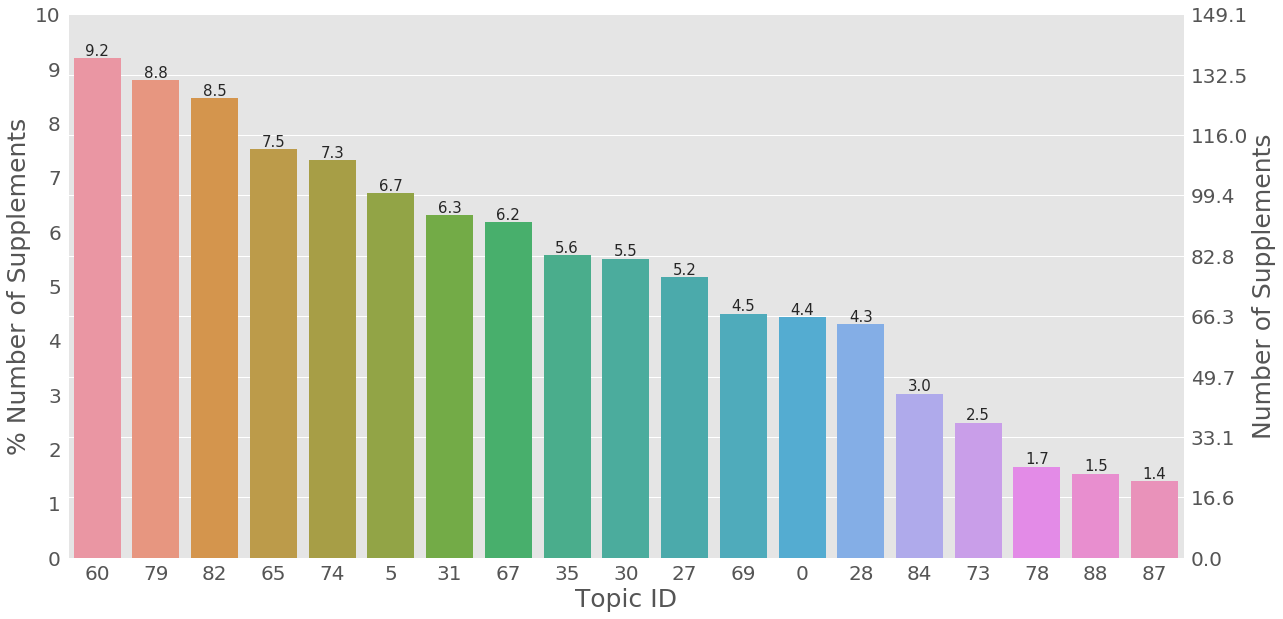

In [50]:
ncount = len(DS_label_topic_select_df)
fig = plt.figure(figsize=(20, 10))
ax = sns.countplot(x='BestTopicID', data=DS_label_topic_select_df,
              order = DS_label_topic_select_df['BestTopicID'].value_counts().index);
make_twin_axis(ax, ncount, 10, '% Number of Supplements')
ax.set_ylabel('Number of Supplements', fontsize=25);
ax.set_xlabel('Topic ID', fontsize=25);
fig.savefig('SupplementDistribution.png', bbox_inches='tight')

## Clean up the ingredients  and ingredient categories column

In [51]:
def remove_text_inside_brackets(text, brackets="()[]{}"):
    count = [0] * (len(brackets) // 2) # count open/close brackets
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: # found bracket
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close # `+1`: open, `-1`: close
                if count[kind] < 0: # unbalanced bracket
                    count[kind] = 0  # keep it
                else:  # found bracket to remove
                    break
        else: # character is not a [balanced] bracket
            if not any(count): # outside brackets
                saved_chars.append(character)
    return ''.join(saved_chars)

In [52]:
def create_clean_ingredient_list(ingredients):
    return [item.strip().replace(' ', '_')
            for item in remove_text_inside_brackets(ingredients).lower().split(',')]

In [53]:
DS_label_topic_select_df['Ingredients'] = (DS_label_topic_select_df['Ingredient_Synonym_Source']
                                                         .apply(create_clean_ingredient_list))
DS_label_topic_select_df['Ingredients'].sample(5)

DSLD_ID
45150    [epazote_powder, wormwood_powder, proprietary_...
11910                                                [msm]
70227                             [dehydroepiandrosterone]
25048    [l-valine, super_protein_amino_acid_profile, p...
12429    [botanical_joint_support_blend, glucosamine_po...
Name: Ingredients, dtype: object

In [54]:
def create_clean_ingredient_cat_list(categories):
    return [item.strip().replace(' ', '_')
            for item in categories.lower().split(',')]

In [55]:
DS_label_topic_select_df['Ingredient_Categories'] = (DS_label_topic_select_df['Ingredient_Categories']
                                                            .apply(create_clean_ingredient_cat_list))
DS_label_topic_select_df['Ingredient_Categories'].sample(5)

DSLD_ID
57235                                            [vitamin]
62518      [mineral, other, header, amino_acid, botanical]
26838                                           [chemical]
42703    [mineral, other, header, carbohydrate, vitamin...
6507              [amino_acid, botanical, blend, chemical]
Name: Ingredient_Categories, dtype: object

In [56]:
print('Selected topics Main Dataframe dimension:', DSL_topic_select_df.shape)
DSL_topic_select_df.sample(5)

Selected topics Main Dataframe dimension: (19, 4)


,TopicID,Number_of_Supplements,Terms,Number_of_Terms
31,74,109,"[erectile_dysfunction, chest_pain, pain, chest...",7
21,60,137,"[increased, difficulty_sleeping, anxiety, nerv...",6
57,87,21,"[gastrointestinal_disorder, bladder_dysfunctio...",6
38,27,77,"[hypertension, hypotension, skin_warm, drug_to...",4
44,28,64,"[prostate_cancer, hypertrophy, breast_cancer, ...",4


## Get all the ingredients and categories for each of the selected topics

In [57]:
filter_empty = lambda lst: [item for item in lst if len(item)>0]

df = (DS_label_topic_select_df.groupby('BestTopicID', as_index=False, sort=False)
        [['Ingredient_Categories', 'Ingredients']]
        .agg(sum))
df['Ingredient_Categories'] = df['Ingredient_Categories'].apply(filter_empty)
df['Ingredients'] = df['Ingredients'].apply(filter_empty)
print('Selected topics Dataframe dimension:', df.shape)
df.sample(5)

Selected topics Dataframe dimension: (19, 3)


,BestTopicID,Ingredient_Categories,Ingredients
9,60,"[vitamin, other, other, vitamin, amino_acid, b...","[the_hit, vitamin_b12, vitamin_b1, vitamin_b5,..."
7,30,"[mineral, enzyme, botanical, other, vitamin, c...","[licorice_root_extract, wild_rosella_calyx, hi..."
8,78,"[chemical, chemical, chemical, chemical, miner...","[salicin, salicin, 7-keto_dhea, yohimbine_hcl,..."
11,84,"[mineral, vitamin, amino_acid, chemical, heade...","[l-valine, agmatine_sulfate, caffeine, l-leuci..."
4,82,"[blend, other, polysaccharide, vitamin, chemic...","[hyaluronic_acid, collagen_type_ii, triple_act..."


In [58]:
DSL_topic_select_df = pd.merge(left=DSL_topic_select_df, right=df, left_on='TopicID', right_on='BestTopicID')
DSL_topic_select_df.drop(['BestTopicID'], axis=1, inplace=True)
print('Selected topics Main Dataframe dimension:', DSL_topic_select_df.shape)
DSL_topic_select_df.head()

Selected topics Main Dataframe dimension: (19, 6)


,TopicID,Number_of_Supplements,Terms,Number_of_Terms,Ingredient_Categories,Ingredients
0,60,137,"[increased, difficulty_sleeping, anxiety, nerv...",6,"[vitamin, other, other, vitamin, amino_acid, b...","[the_hit, vitamin_b12, vitamin_b1, vitamin_b5,..."
1,79,131,"[obstruction, intestinal_obstruction, pain, ab...",8,"[mineral, botanical, other, mineral, other, mi...","[chinese_rhubarb__powder, fenugreek_powder, po..."
2,82,126,"[pain_skin, pain, abdominal_pain, fatigue, vom...",10,"[blend, other, polysaccharide, vitamin, chemic...","[hyaluronic_acid, collagen_type_ii, triple_act..."
3,65,112,"[dehydration, low, liver_disorder, cardiac_dis...",10,"[vitamin, botanical, other, mineral, amino_aci...","[rhodiola_rosea_extract, proprietary_blend, ar..."
4,74,109,"[erectile_dysfunction, chest_pain, pain, chest...",7,"[amino_acid, amino_acid, mineral, other, heade...","[l-citrulline, l-citrulline, calories, sugars,..."


In [59]:
flatten = lambda l: [item for sublist in l for item in sublist if len(item)>0]
icat_vocab_ = list(set(flatten(DSL_topic_select_df['Ingredient_Categories'])))

print('Number of unique Ingredient Categories: {}'.format(len(icat_vocab_)))

Number of unique Ingredient Categories: 19


In [60]:
flatten = lambda l: [item for sublist in l for item in sublist if len(item)>0]
ingr_vocab_ = list(set(flatten(DSL_topic_select_df['Ingredients'])))

print('Number of unique Ingredients: {}'.format(len(ingr_vocab_)))

Number of unique Ingredients: 3072


## Find the most frequent ingredient & category for each topic using Counts

In [61]:
count_vectorizer = CountVectorizer(lowercase=False, vocabulary=icat_vocab_, 
                                   max_df=1.0, min_df=1, binary=False)
counts_vectors  = count_vectorizer.fit_transform(DSL_topic_select_df['Ingredient_Categories']
                                                 .apply(lambda x: ' '.join(x)))
counts_features = count_vectorizer.get_feature_names()
print('Number of terms from CountVectorizer:', len(counts_features))

Number of terms from CountVectorizer: 19


In [62]:
ingr_cat_cnt_topic = counts_vectors.toarray()
print('Dimension of count matrix:', ingr_cat_cnt_topic.shape)
DSL_topic_select_df['Common_Ingredient_Category_Count'] = list(np.array(counts_features)
                                                         [list(ingr_cat_cnt_topic.argmax(axis=1))])

Dimension of count matrix: (19, 19)


In [63]:
count_vectorizer = CountVectorizer(lowercase=False, vocabulary=ingr_vocab_, 
                                   max_df=1.0, min_df=1, binary=False)
counts_vectors  = count_vectorizer.fit_transform(DSL_topic_select_df['Ingredients']
                                                 .apply(lambda x: ' '.join(x)))
counts_features = count_vectorizer.get_feature_names()
print('Number of terms from CountVectorizer:', len(counts_features))

Number of terms from CountVectorizer: 3072


In [64]:
ingr_cnt_topic = counts_vectors.toarray()
print('Dimension of count matrix:', ingr_cnt_topic.shape)
DSL_topic_select_df['Common_Ingredient_Count'] = list(np.array(counts_features)
                                                         [list(ingr_cnt_topic.argmax(axis=1))])

Dimension of count matrix: (19, 3072)


## Find the most frequent ingredient & category for each topics using TfIdf

In [65]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True, 
                                   max_df=1.0, min_df=1, vocabulary=icat_vocab_)
tfidf_vectors  = tfidf_vectorizer.fit_transform(DSL_topic_select_df['Ingredient_Categories']
                                                 .apply(lambda x: ' '.join(x)))
tfidf_features = tfidf_vectorizer.get_feature_names()
print('Number of terms from TfidfVectorizer:', len(tfidf_features))

Number of terms from TfidfVectorizer: 19


In [66]:
ingr_cat_tfidf_topic = tfidf_vectors.toarray()
print('Dimension of tfidf matrix:', ingr_cat_tfidf_topic.shape)
DSL_topic_select_df['Common_Ingredient_Category_Tfidf'] = list(np.array(tfidf_features)
                                                         [list(ingr_cat_tfidf_topic.argmax(axis=1))])

Dimension of tfidf matrix: (19, 19)


In [67]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True, 
                                   max_df=1.0, min_df=1, vocabulary=ingr_vocab_)
tfidf_vectors  = tfidf_vectorizer.fit_transform(DSL_topic_select_df['Ingredients']
                                                 .apply(lambda x: ' '.join(x)))
tfidf_features = tfidf_vectorizer.get_feature_names()
print('Number of terms from TfidfVectorizer:', len(tfidf_features))

Number of terms from TfidfVectorizer: 3072


In [68]:
ingr_tfidf_topic = tfidf_vectors.toarray()
print('Dimension of tfidf matrix:', ingr_tfidf_topic.shape)
DSL_topic_select_df['Common_Ingredient_Tfidf'] = list(np.array(tfidf_features)
                                                         [list(ingr_tfidf_topic.argmax(axis=1))])

Dimension of tfidf matrix: (19, 3072)


In [69]:
DSL_topic_select_df

,TopicID,Number_of_Supplements,Terms,Number_of_Terms,Ingredient_Categories,Ingredients,Common_Ingredient_Category_Count,Common_Ingredient_Count,Common_Ingredient_Category_Tfidf,Common_Ingredient_Tfidf
0,60,137,"[increased, difficulty_sleeping, anxiety, nerv...",6,"[vitamin, other, other, vitamin, amino_acid, b...","[the_hit, vitamin_b12, vitamin_b1, vitamin_b5,...",botanical,caffeine_anhydrous,botanical,myristica_fragrans_extract
1,79,131,"[obstruction, intestinal_obstruction, pain, ab...",8,"[mineral, botanical, other, mineral, other, mi...","[chinese_rhubarb__powder, fenugreek_powder, po...",botanical,calcium,fiber,slippery_elm_powder
2,82,126,"[pain_skin, pain, abdominal_pain, fatigue, vom...",10,"[blend, other, polysaccharide, vitamin, chemic...","[hyaluronic_acid, collagen_type_ii, triple_act...",botanical,calories,botanical,kava_kava_extract
3,65,112,"[dehydration, low, liver_disorder, cardiac_dis...",10,"[vitamin, botanical, other, mineral, amino_aci...","[rhodiola_rosea_extract, proprietary_blend, ar...",chemical,calories,amino_acid,creatine_ethyl_ester
4,74,109,"[erectile_dysfunction, chest_pain, pain, chest...",7,"[amino_acid, amino_acid, mineral, other, heade...","[l-citrulline, l-citrulline, calories, sugars,...",amino_acid,calories,polysaccharide,explosive_energy_blend
5,5,100,"[inflammation, gallbladder_disorder, obstructi...",6,"[botanical, carbohydrate, other, mineral, head...","[milk_thistle__seed_extract, licorice__root_an...",botanical,total_carbohydrate,botanical,chlorophyllin
6,31,94,"[infarction, myocardial_infarction, renal_fail...",4,"[mineral, botanical, chemical, other, other, v...","[potassium, ammonium, chloride, creatine_ethyl...",amino_acid,arginine,amino_acid,aakg
7,67,92,"[redness, clotting, feeling_hot, skin_irritati...",6,"[mineral, blend, other, header, enzyme, vitami...","[energy_blend, protease, n-acetyl_l-tyrosine, ...",vitamin,niacin,vitamin,phosphatidylserine_complex
8,35,83,"[gastrointestinal_pain, pain, breast_pain, bre...",8,"[botanical, botanical, botanical, chemical, bo...","[cayenne_pepper, cayenne_pepper, cayenne_peppe...",botanical,red_yeast_rice_powder,botanical,red_yeast_rice_powder
9,30,82,"[tingling_skin, tingling_sensation, sensation_...",6,"[mineral, enzyme, botanical, other, vitamin, c...","[licorice_root_extract, wild_rosella_calyx, hi...",amino_acid,alanine,amino_acid,muscle_power_blend


## Find the representative ingredient for each topic

In [70]:
def print_lda_topic_words(lda_model, topicID):
    threshold = 0.02
    for topic in topicID:
        top_terms_tup = lda_model.show_topic(topic, topn=20)
        print ("Topic #", topic, ': ', [tup[0] for tup in top_terms_tup if tup[1] >= threshold])

In [71]:
def get_meddra_topic_common_terms(row):
    meddra, topic = row
    return list(set(meddra) & set(topic))

In [72]:
DS_label_topic_select_df['MedDRA_Topic_Common_Terms'] = (DS_label_topic_select_df[['MedDRA_SE', 'BestTopicTerms']]
                                                         .apply(get_meddra_topic_common_terms, axis=1))

In [75]:
topic = 60
select_cols = ['Product_Name', 'MedDRA_SE', 'Ingredients', 'MedDRA_Topic_Common_Terms']
DS_label_topic_select_df[DS_label_topic_select_df['BestTopicID']==topic][select_cols]

,Product_Name,MedDRA_SE,Ingredients,MedDRA_Topic_Common_Terms
DSLD_ID,,,,
18739,ANS Performance Hit,"[anxiety, headache, palpitations, difficulty_s...","[the_hit, vitamin_b12, vitamin_b1, vitamin_b5,...","[anxiety, headache, increased, palpitations, d..."
39467,ANS Performance Pro Thermogenic Diablo Electri...,"[anxiety, headache, palpitations, difficulty_s...","[adilase, l-carnitine_l-tartrate, olive_leaf_e...","[anxiety, headache, increased, palpitations, d..."
39468,ANS Performance Pro Thermogenic Diablo Pineapp...,"[anxiety, headache, palpitations, difficulty_s...","[adilase, l-carnitine_l-tartrate, olive_leaf_e...","[anxiety, headache, increased, palpitations, d..."
79840,BPI Sports 1.M.R Apple Pear,"[dizziness, body_temperature_increased, headac...","[1_mr_endurance_matrix, gamma-butyrobetaine_et...","[nervousness, increased, headache]"
79844,BPI Sports 1.M.R Blueberry Lemonade,"[dizziness, body_temperature_increased, headac...","[1_mr_endurance_matrix, gamma-butyrobetaine_et...","[nervousness, increased, headache]"
79846,BPI Sports 1.M.R Fruit Punch,"[dizziness, body_temperature_increased, headac...","[1_mr_endurance_matrix, gamma-butyrobetaine_et...","[nervousness, increased, headache]"
79852,BPI Sports 1.M.R Peach Cobbler,"[dizziness, body_temperature_increased, headac...","[1_mr_endurance_matrix, gamma-butyrobetaine_et...","[nervousness, increased, headache]"
79857,BPI Sports 1.M.R Rainbow Ice,"[dizziness, body_temperature_increased, headac...","[1_mr_endurance_matrix, gamma-butyrobetaine_et...","[nervousness, increased, headache]"
70840,EFX Sports Kre-Alkalyn Hardcore,"[anxiety, palpitations, irritability, difficul...","[kre-alkalyn, theobromine, razberi-k, theophyl...","[anxiety, palpitations, difficulty_sleeping]"


In [74]:
flatten = lambda l: [item for sublist in l for item in sublist if len(item)>0]
for topic in final_selected_topics:
    print_lda_topic_words(opt_lda_model, [topic])
    print(Counter(flatten(DS_label_topic_select_df[DS_label_topic_select_df['BestTopicID']==topic]
                          ['Ingredients'])).most_common(5))
    print('\n')

Topic # 60 :  ['increased', 'difficulty_sleeping', 'anxiety', 'nervousness', 'palpitations', 'headache']
[('caffeine_anhydrous', 111), ('calories', 67), ('beta-alanine', 53), ('total_carbohydrate', 52), ('yohimbe_extract', 42)]


Topic # 79 :  ['obstruction', 'intestinal_obstruction', 'pain', 'abdominal_pain', 'loose_stools', 'colon_obstruction', 'dehydration', 'abdominal_disorder']
[('calcium', 41), ('proprietary_blend', 34), ('total_carbohydrate', 33), ('slippery_elm_powder', 30), ('ginger_powder', 29)]


Topic # 82 :  ['pain_skin', 'pain', 'abdominal_pain', 'fatigue', 'vomiting', 'yellow_skin', 'injury', 'liver_injury', 'abdominal_injury', 'drowsiness']
[('calories', 29), ('kava_kava_extract', 19), ('calcium', 15), ('kavalactones', 14), ('proprietary_extract_blend', 13)]


Topic # 65 :  ['dehydration', 'low', 'liver_disorder', 'cardiac_disorder', 'thyroid_disorder', 'blood_disorder', 'arrhythmia', 'heat_stroke', 'preexisting_disease', 'dizziness']
[('calories', 55), ('taurine', 47),

In [ ]:
DS_label_topic_select_df.to_csv('data/DietarySupplementLabelSelectTopic.csv')

# Visualizing the model with pyLDAvis

In [76]:
vis_data = gensimvis.prepare(lmlist[6], corpus_dict, dictionary)
pyLDAvis.display(vis_data)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
